### Arm Take-Home Exercise
We will begin by importing the various libraries which will be needed for the task:
- Pandas, a library for data manipulation/analysis with built in CSV loading methods
- Matplotlib, a plotting library
- Numpy, a scientific computing package

Following this, the csvs are then read into pandas "Dataframe" structure.

In [1]:
"""Load CSVs into a pandas dataframe"""

#load various imports needed for the task
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

#Import CSVs using pandas read_csv method
counts_df = pd.read_csv("counts.csv")
patients_df = pd.read_csv("patientdata.csv")

Let us quickly display the first 3 rows of each dataframe, to check they were read correctly:

In [2]:
counts_df.head(3)

,GivenName,Surname,count
0,Holly,Humphries,531
1,Robert,Hobbs,750
2,Charlie,Kemp,738


In [3]:
patients_df.head(3)

,GivenName,Surname,Gender,Age,BloodType,Weight,Height,Latitude,Longitude
0,Anthony,Wheeler,male,28.0,O-,65.8,188,51.144501,1.291749
1,Evie,Read,female,50.0,O+,81.6,162,51.397614,-1.847534
2,Jasmine,Newman,female,67.0,O+,71.1,170,50.360648,-4.238866


The first task is to remove non-unique entries in each dataframe, based on a combination of the first and last names. This could be implemented relatively simply, but pandas already has a method, which is more than likely optimized for their data structure, so lets use that.

In [4]:
#store the duplicated values in an array, as they will be written to text
counts_duplicated_df = counts_df[counts_df.duplicated(['GivenName', 'Surname'])]
patients_duplicated_df = patients_df[patients_df.duplicated(['GivenName', 'Surname'])]

#method to concatonate first and last name for a given dataframe
def name_list(dataframe):
    return [row.GivenName + " " + row.Surname for index, row in dataframe.iterrows()]

#Assert the same rows in each dataframe are duplicated
assert set(name_list(counts_duplicated_df)) == set(name_list(patients_duplicated_df))

#Store the lengths so we can later confirm the rows were removed correctly
original_length = counts_df.shape[0]
duplicated_length = counts_duplicated_df.shape[0]

counts_df = counts_df.drop(counts_duplicated_df.index.values)
patients_df = patients_df.drop(patients_duplicated_df.index.values)
assert original_length - duplicated_length == counts_df.shape[0]

In [5]:
#Now lets save the duplicated list to text
def save_txt(X, filename):
    with open(filename, "w") as txt:
        [txt.write(str(xi) + "\n") for xi in X]
    print ("Succesfully saved to: \'{}\'".format(filename))

save_txt(name_list(counts_duplicated_df), "part1.txt")

Succesfully saved to: 'part1.txt'


In [6]:
#Two approaches, built in method for merging two dataframes, or sort each then concat.
#Use pandas method for efficiency

joined_df = pd.merge(counts_df, patients_df, on=['GivenName', 'Surname'])

#check
joined_df.head(3)

,GivenName,Surname,count,Gender,Age,BloodType,Weight,Height,Latitude,Longitude
0,Holly,Humphries,531,female,63.0,O+,61.4,167,50.401616,-4.113327
1,Robert,Hobbs,750,male,53.0,B+,69.5,176,57.315848,-2.764894
2,Charlie,Kemp,738,male,NaN,A+,64.0,184,54.833653,-3.777728


In [7]:
#save number of rows to txt file
save_txt([joined_df.shape[0]], "part2.txt")

Succesfully saved to: 'part2.txt'


In [8]:
columns_withnan = joined_df.columns[joined_df.isnull().any()].tolist()
rows_withnan = int(np.sum(pd.isnull(joined_df).sum()))

In [9]:
rows_withnan

17

In [10]:
save_txt(["Following columns have missing values: {}".format(columns_withnan),
         "{} rows with missing values".format(rows_withnan)], "part3.txt")

Succesfully saved to: 'part3.txt'


In [11]:
joined_df = joined_df.dropna()
#confirm size is now 981
joined_df.shape[0]

#save as csv - use pandas function
joined_df.to_csv("part4.csv")

In [12]:
#convert categorical variables to discrete integers
joined_df['Gender'] = joined_df['Gender'].astype('category')
joined_df['BloodType'] = joined_df['BloodType'].astype('category')

categorical_columns = joined_df.select_dtypes(['category']).columns

joined_df[categorical_columns] = joined_df[categorical_columns].apply(lambda x: x.cat.codes)

#Check 
joined_df.head(3)

,GivenName,Surname,count,Gender,Age,BloodType,Weight,Height,Latitude,Longitude
0,Holly,Humphries,531,0,63.0,6,61.4,167,50.401616,-4.113327
1,Robert,Hobbs,750,1,53.0,4,69.5,176,57.315848,-2.764894
3,Joshua,Willis,651,1,49.0,6,67.5,184,50.801275,0.225528


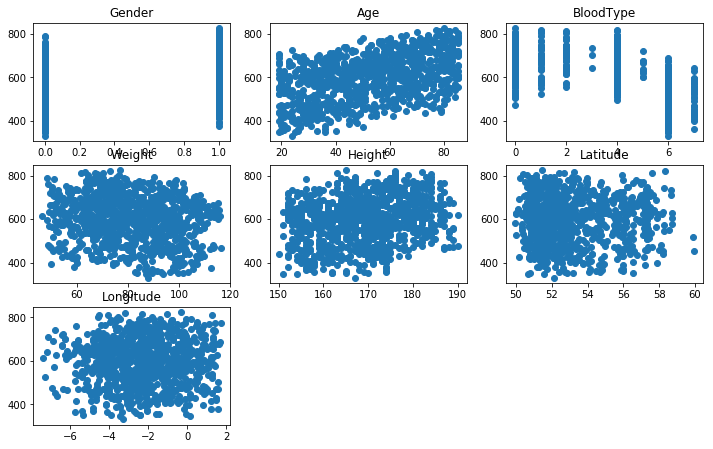

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 10
#plot each feature with target "count"
joined_mat = joined_df.values
for i in range(3, joined_mat.shape[1]):
    ax = plt.subplot(4, 3, i - 2)
    ax.set_title(joined_df.columns.values[i])
    ax.scatter(joined_mat[:, i], joined_mat[:, 2])

Obviously there could be some multivariate correlation, however these are going to be ignored for now, a regressor will be trained to get an initial reading of the error. Ultimately the error will be limited by the noise in the data.

In [23]:
from sklearn.linear_model import LinearRegression
"""
As the task said linear regression I selected the standard SKlearn LinearRegression
Would have used an SVR, even though they're technically linear their kernel transformation
produces 'non-linear' results.

Ideally an RBF would have been used, with a gaussian kernel, but again, not linear.

Apologies if you wanted me to implement something myself, I would be happy to if you ask
"""

#Shuffle the data
np.random.shuffle(joined_mat)

#split data into training/test sets
testing_data = joined_mat[:joined_mat.shape[0] * 0.2]
training_data = joined_mat[joined_mat.shape[0] * 0.2:]

#r2 error calc - I know sklearn's regressor has this built in, I just wrote it before I remembered :(
def r2_error(pred_y, true_y):
    return 1 - (np.sum((true_y - pred_y) ** 2) / np.sum((true_y - np.mean(true_y)) ** 2))

model = LinearRegression(fit_intercept=True).fit(training_data[:, 3:], training_data[:, 2])
r2_training = r2_error(model.predict(training_data[:, 3:]) , training_data[:, 2])
r2_testing = r2_error(model.predict(testing_data[:, 3:]) , testing_data[:, 2])

print("Training Residual: {}, Testing Residual: {}".format(r2_training, r2_testing))

Training Residual: 0.77668700735868, Testing Residual: 0.7887942706670034


G:\Users\Bradley\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
G:\Users\Bradley\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
